## 자전거 수요 예측

### 필요한 라이브러리 불러오기 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy

### 데이터 불러오기 

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submissopn = pd.read_csv('dataset/sampleSubmission.csv')

### 데이터 확인

In [3]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [4]:
test.columns
# count를 예측해야하는 문제 

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [5]:
# 데이터를 적절하게 변형할 차례 
# 테스트 데이터도 꼭 변경해줘야 함!!!!

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [6]:
train.info()
# objets -- > datetime64[ns] 로 변경됨을 확인할 수 있음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
train.shape # 10886
test.shape # 6493

(6493, 9)

### 데이터 EDA 진행

In [8]:
# 1. 기준별 자전거 수요량 확인하기 .
# datetime 의 연, 월, 일, 시, 분, 초로 나누어 자전거 수요량 확인

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

In [9]:
# day of week 은 요일을 가져오기도 함 
train['dayofweek'] = train['datetime'].dt.dayofweek
train['dayofweek']

0        5
1        5
2        5
3        5
4        5
        ..
10881    2
10882    2
10883    2
10884    2
10885    2
Name: dayofweek, Length: 10886, dtype: int64

In [10]:
# test 데이터에도 동일하게 진행
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek

<AxesSubplot:xlabel='year', ylabel='count'>

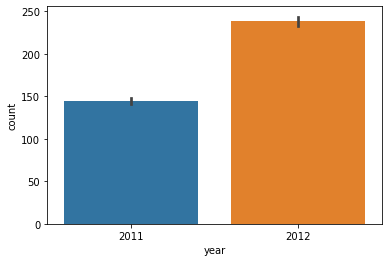

In [11]:
# 연도별 자전거 수요량

sns.barplot(data = train, x = 'year', y = 'count')
# 년도가 증가함에 따라 갑자기 수요량이 증가했음
# 예측에 사용될 수 있겠다.

<AxesSubplot:xlabel='month', ylabel='count'>

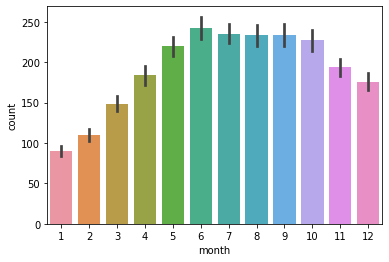

In [12]:
# month 별 자전거 수요량 

sns.barplot(data=train, x='month', y='count')
# 월별 차이도 존재하므로 예측에 사용할 수 있겠다

<AxesSubplot:xlabel='day', ylabel='count'>

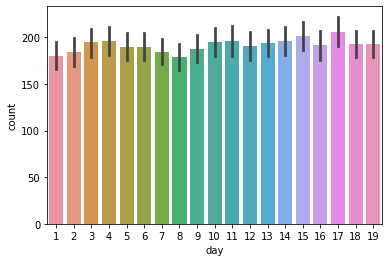

In [13]:
# day별 자전거 수요량
sns.barplot(data=train, x='day',y='count')

<AxesSubplot:xlabel='season', ylabel='count'>

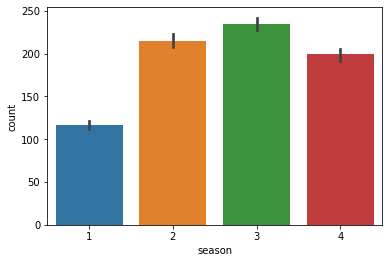

In [14]:
# season 별 자전거 수요량 
sns.barplot(data=train, x='season', y='count')

In [15]:
# 계절을 나누는 기준이 뭘까. 확인해보자 
train[train['season']==1].month.unique() # 1 회색 겨울 : 1,2,3
train[train['season']==2].month.unique() # 2: 분홍빛 봄 :4,5,6
# season도 차이가 존재하므로 예측 변수로 사용할 수 있겠다

array([4, 5, 6], dtype=int64)

<AxesSubplot:xlabel='hour', ylabel='count'>

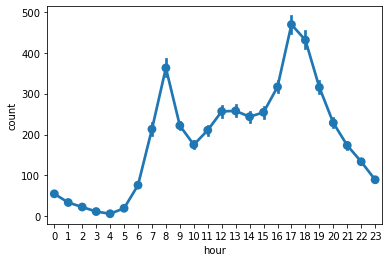

In [16]:
# 시간대별 꺽은선 그래프를 확인해보자
# 꺽은선 = point plot

# fig, ax1 = plt.subplot(1,1)
# fig.set_size_inches(20,5) # 사이즈 조절
sns.pointplot(data=train, x='hour',y='count')

# 8시나 17시 경에 자전거 수요량이 가장 많다. 출퇴근 시간으로 예상됨

In [17]:
train.isnull().sum()
# 갑자기 결측치 있는지 확인해보고 싶어서 돌려본 코드......

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
minute        0
second        0
dayofweek     0
dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

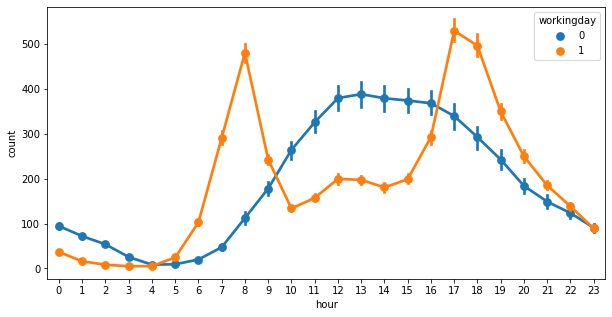

In [18]:
# working (카테고리형), 시간대별로 pointplot 확인

# hue 변수를 사용해서 카테고리형 데이터를 고려한 그래프를 출력 가능

f, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.pointplot(data=train, x ='hour',y='count', hue='workingday', ax=ax)

# 1 : 근무날에는 출퇴근 시간에 이용량이 많고, 근무날 아닐때는 그냥 오후쯤

<AxesSubplot:xlabel='hour', ylabel='count'>

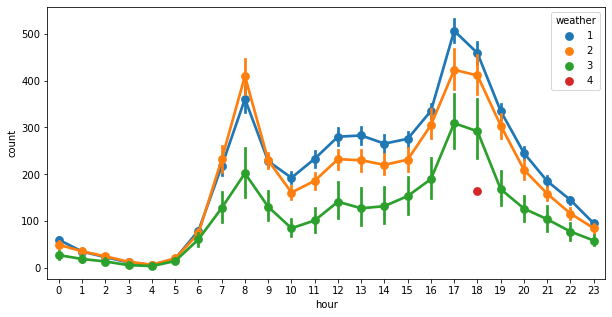

In [19]:
# weather - 카테고리형, 시간대별로 pointplt
f, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.pointplot(data=train, x='hour', y='count', hue='weather')

# 날씨 좋은날일수록 자전거 이용량이 많고, 나쁠수록 적음

<AxesSubplot:xlabel='hour', ylabel='count'>

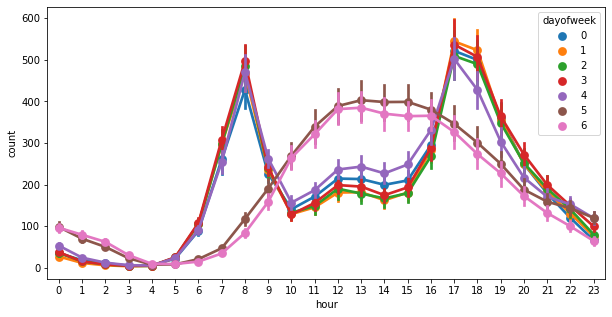

In [20]:
# 요일별도 찾아보자 
f, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek')


In [21]:
# year, month, day, hour
# weather, holiday, workingday, dayofweek, season
# 사용해볼 것

### 변수끼리의 상관관계

<AxesSubplot:>

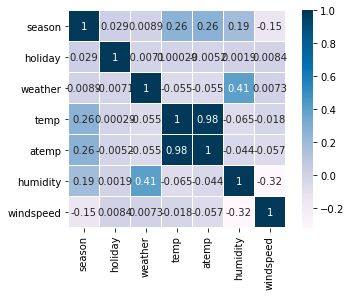

In [22]:
corr_data = train[['datetime', 'season', 'holiday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
# 변수 여러개 데려가려면 이렇게 괄호 2번 해야됨 

colormap = plt.cm.PuBu
sns.heatmap(corr_data.corr(), linewidths = 0.1, square = True, annot = True, cmap = colormap)

# temp랑 atemp가 유독 상관관계가 높아서 다중공선성 의심
# temp, atemp 둘 중 한 변수만 사용해야겠다.


<AxesSubplot:xlabel='windspeed', ylabel='count'>

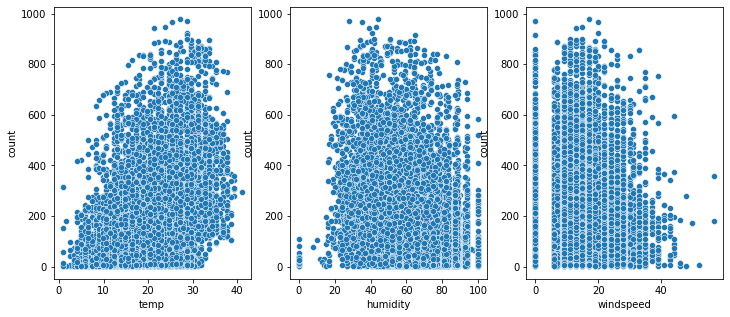

In [23]:
# 온도, 습도, 바람세기에 대해 알아보기
# 연속형 변수라서 scatter plot을 사용해 확인할 것임

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

sns.scatterplot(data=train, x='temp', y='count',ax=ax1)
sns.scatterplot(data=train, x='humidity', y='count',ax=ax2)
sns.scatterplot(data=train, x='windspeed', y='count',ax=ax3)

# 근데 확인해보니 바람세기가 0인 자료들이 꽤 존재함.
# 바람세기가 0일 수 있냐는 의문 

In [24]:
# 바람세기 0인 자료들 몇개 인지 확인

len(train[train['windspeed']==0]) #1313개 
# 0인 값을 대체하는 feature engineering을 수행하는 것

1313

### Feature Engineering

In [25]:
'''
총 3단계로 진행 

- IQR방법으로 이상치를 제거한 뒤
- 데이터의 왜도와 첨도를 살펴보고 조절 
- windspeed에 대한 feature engineering 진행
'''

'\n총 3단계로 진행 \n\n- IQR방법으로 이상치를 제거한 뒤\n- 데이터의 왜도와 첨도를 살펴보고 조절 \n- windspeed에 대한 feature engineering 진행\n'

#### 1) IQR 방법으로 이상치 제거

<AxesSubplot:xlabel='count'>

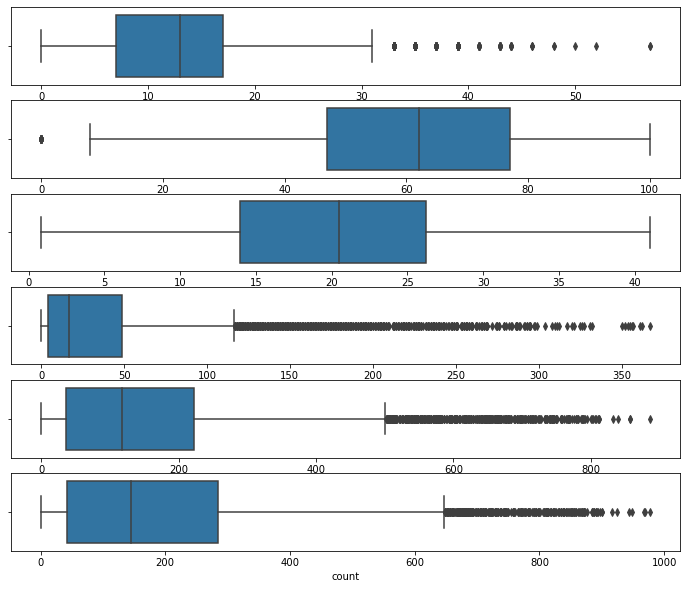

In [26]:
# 이상치 제거 - 연속형 변수들에 대한 boxplot으로 확인

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12,10))
sns.boxplot(data = train, x = 'windspeed', ax = ax1)
sns.boxplot(data = train, x = 'humidity', ax = ax2)
sns.boxplot(data = train, x = 'temp', ax = ax3)
sns.boxplot(data = train, x = 'casual', ax = ax4)
sns.boxplot(data = train, x = 'registered', ax = ax5)
sns.boxplot(data = train, x = 'count', ax = ax6)

In [27]:
# IQR 방식을 사용한 이상치 제거 함수

from collections import Counter
def detect_outliers(data, n, cols):
    outlier_indices = []

    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

In [28]:
# 연속형 변수들을 집어서 넣어서 확인해 줌 
# boxplot 그릴때는 temp랑 atemp비슷해서 하나만 확인했지만
# 결측치는 잘 제거해줘야하는거니까 모든 변수 다 넣어서 확인

Outliers_to_drop = detect_outliers(train, 2, ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"])

In [29]:
train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10841,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0,2
10842,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0,2
10843,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0,2
10844,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0,2


In [30]:
# train에 저장
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
train.shape
# 10886 -- > 10846

(10846, 19)

#### 2) 왜도와 첨도 확인

In [31]:
# 왜도와 첨도 확인
'''
왜도
(-2 ~ +2)정도 되어야 치우침이 없는 데이터
- positive : square root, cube, log
- negative : square, cube root, logarithmic(밑2)

첨도
뾰족함에 집중하기 보다 tail에 대한 모든 것들 확인
첨도가 높다 = outlier가 많이 있다

'''

'\n왜도\n(-2 ~ +2)정도 되어야 치우침이 없는 데이터\n- positive : square root, cube, log\n- negative : square, cube root, logarithmic(밑2)\n\n첨도\n뾰족함에 집중하기 보다 tail에 대한 모든 것들 확인\n첨도가 높다 = outlier가 많이 있다\n\n'

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness(왜도): 1.210923
kurtosis(첨도): 1.200871


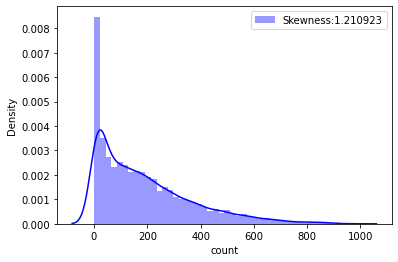

In [32]:
# 히스토그램을 그려서 확인해보자  distplot

# fig, ax = plt.subplot(1,1, figsize = (10,6))
graph = sns.distplot(train['count'], color='b', label='Skewness:{:2f}'.format(train['count'].skew()))
graph = graph.legend(loc='best')
print('skewness(왜도): %f' %train['count'].skew())
print('kurtosis(첨도): %f' %train['count'].kurt())

# 수치상으론 둘 다 별 문제는 없지만, 그림을 그려보면 count가 0에 굉장히 많이 치우져져 있음
# log scaling을 통해 정규화하는 작업이 필요

#### log scaling을 통한 정규화 작업

In [33]:
'''
y값이 log를 취했으니 나중에 나온 예측 결과에도 다시 log를 취해주어야 함
count에 log를 취해준 count값을 cout_log 컬럼으로 생성 
'''
train['count'].map(lambda i:np.log(i) if i >0 else 0)

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10841    5.817111
10842    5.484797
10843    5.123964
10844    4.859812
10845    4.477337
Name: count, Length: 10846, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness(왜도): -0.975198
kurtosis(첨도): 0.247435


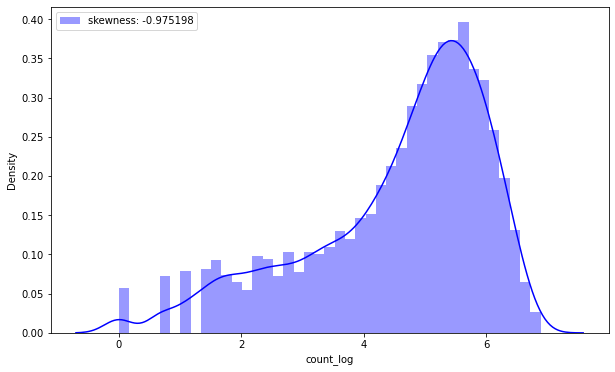

In [34]:
train['count_log'] = train['count'].map(lambda i:np.log(i) if i >0 else 0)
fig, ax = plt.subplots(1,1, figsize = (10, 6))
graph = sns.distplot(train['count_log'], color = 'b', label = 'skewness: {:2f}'.format(train['count_log'].skew()), ax = ax)
graph = graph.legend(loc = 'best')

print("skewness(왜도): %f" %train['count_log'].skew())
print("kurtosis(첨도): %f" %train['count_log'].kurt())

In [35]:
# 필요없는 count 값으 train에서 없애줄 것
train.drop('count', axis = 1, inplace = True)

In [36]:
train.columns
# count 없어지고 count_log 존재

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'count_log'],
      dtype='object')

#### 3) windspeed = 0의 대체값 찾기

In [37]:
'''
풍속이 0일때는 거의 없기 때문에 windspeed 값을 대체해주기로 한다.

<<방법>>
- 결측값을 앞방향 혹은 뒷방향으로 채우가
- 결측값을 변수별 평균으로 채우기
- 결측값을 가진 데이터를 삭제하기
- 결측값을 0이나, 아예 다른 값으로 대체하기 
- 결측값을 예측된 값으로 대체 하기 (ML을 돌려서)
'''

'\n풍속이 0일때는 거의 없기 때문에 windspeed 값을 대체해주기로 한다.\n\n<<방법>>\n- 결측값을 앞방향 혹은 뒷방향으로 채우가\n- 결측값을 변수별 평균으로 채우기\n- 결측값을 가진 데이터를 삭제하기\n- 결측값을 0이나, 아예 다른 값으로 대체하기 \n- 결측값을 예측된 값으로 대체 하기 (ML을 돌려서)\n'

In [38]:
# windspeed 가 null값인 경우를 0으로 처리한 것이라고 생각했기에,
# 결측치를 채우는 방법중에 하나의 방법인 예측된 값으로 대체하는 방법을 사용

#### Random Forest를 활용해 windspeed = 0.0 값 대체하기 

In [39]:
from sklearn.ensemble import RandomForestClassifier
def predict_windspeed(data):
    wind0 = data.loc[data['windspeed'] == 0]
    windnot0 = data.loc[data['windspeed'] != 0]

    # 풍속이 날씨변수이기 때문에 날씨변수를 활용해서 windspeed를 예측해줄 것
    col = ['season', 'weather', 'temp', 'humidity', 'atemp', 'day']

    windnot0['windspeed'] = windnot0['windspeed'].astype('str')

    rf = RandomForestClassifier()
    # windspeed가 0이 아닌 컬럼으로 fit 해줌
    # model.fit(X_train, y_train)
    rf.fit(windnot0[col], windnot0['windspeed'])

    # windspeed가 0인 부분을 예측
    # model.predict(X_test)
    pred_wind0 = rf.predict(X=wind0[col])

    # wind0의 windspeed 값을 pred_wind0으로 바꿔주고
    wind0['windspeed'] = pred_wind0

    # windnot0과 wind0을 합쳐준다
    data = windnot0.append(wind0)
    data['windspeed'] = data['windspeed'].astype('float')

    data.reset_index(inplace=True)
    data.drop("index", inplace=True, axis=1)

    return data

In [40]:
train = predict_windspeed(train)
test = predict_windspeed(test)

<ipython-input-39-f65da5db48fb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')
<ipython-input-39-f65da5db48fb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0['windspeed'] = pred_wind0
<ipython-input-39-f65da5db48fb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [41]:
train[train['windspeed']==0.0]
# 없음을 확인~~

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour,minute,second,dayofweek,count_log


<AxesSubplot:xlabel='windspeed', ylabel='count'>

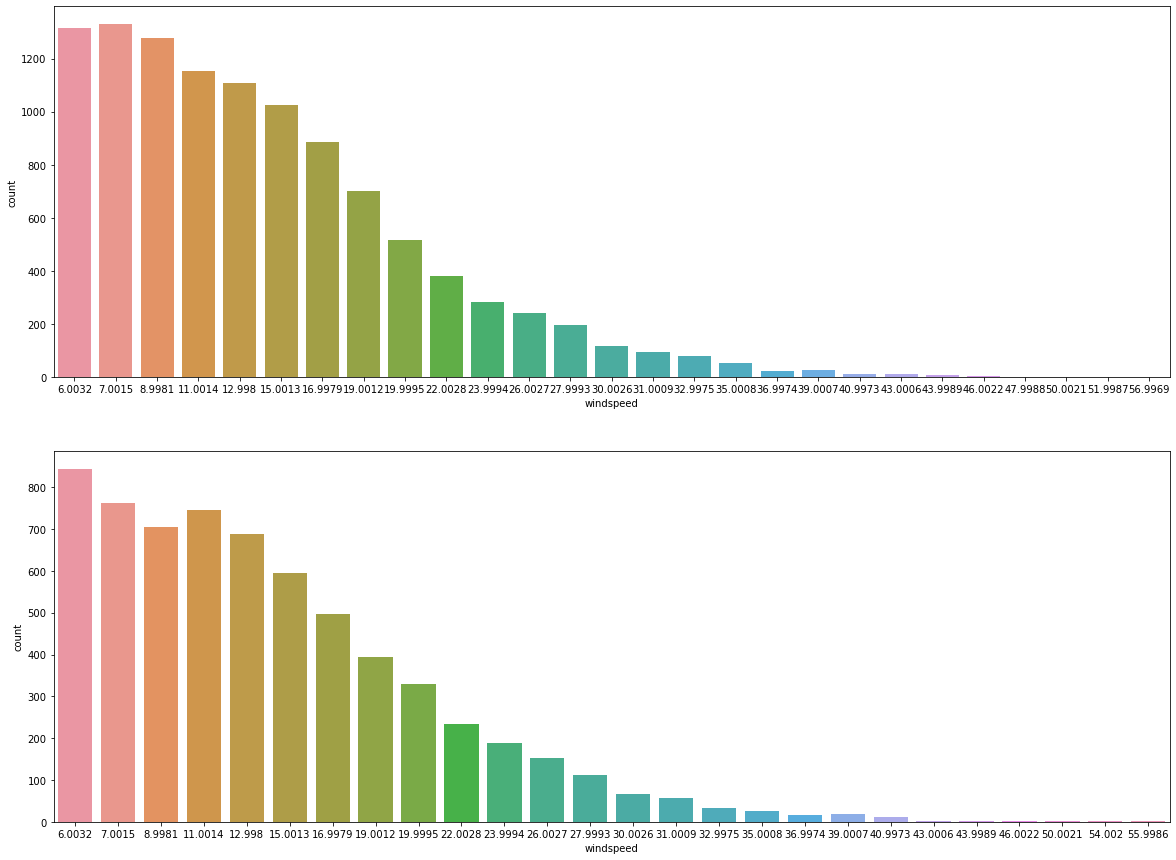

In [42]:
# train과 test의 windspeed 값 시각화

fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(20,15)

# 개수를 세야해서 count plot 사용
sns.countplot(data=train, x = 'windspeed',ax=ax1)
sns.countplot(data=test, x='windspeed', ax=ax2)
# 0값이 없는 것을 확인


### one-hot encoding 범주형 변수 처리

In [43]:
# season, weather, workingday, holiday 변수에 대한 것들

# prefix : 변수 생성 명에 weather_1로 생성되게 하는 것임
train = pd.get_dummies(train, columns=['weather'],prefix ='weather')
test = pd.get_dummies(test, columns=['weather'], prefix='weather')

train = pd.get_dummies(train, columns =['season'], prefix='season')
test = pd.get_dummies(test, columns=['season'], prefix = 'season')

train = pd.get_dummies(train, columns = ['holiday'], prefix = 'holiday')
test = pd.get_dummies(test, columns = ['holiday'], prefix = 'holiday')

In [44]:
train.columns

Index(['datetime', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'dayofweek', 'count_log', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'season_1', 'season_2', 'season_3',
       'season_4', 'holiday_0', 'holiday_1'],
      dtype='object')

In [45]:
test.columns

Index(['datetime', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1'],
      dtype='object')

### Modeling

In [ ]:
'''
train에 사용될 변수를 선택하자.
submission 기준으로 예측값을 적음
그렇기 때문에 다로 test['datetime'] 은 따로 저장해둘 것
'''

In [47]:
test_datetime = test['datetime']
test_datetime

0      2011-01-20 00:00:00
1      2011-01-20 03:00:00
2      2011-01-20 04:00:00
3      2011-01-20 05:00:00
4      2011-01-20 06:00:00
               ...        
6488   2012-12-29 12:00:00
6489   2012-12-29 13:00:00
6490   2012-12-29 15:00:00
6491   2012-12-29 23:00:00
6492   2012-12-30 19:00:00
Name: datetime, Length: 6493, dtype: datetime64[ns]

In [48]:
# t사용 안할 변수들 drop 하기

train.drop(['datetime', 'workingday','atemp','registered','casual','minute','second'], axis = 1, inplace=True)

In [49]:
train.columns
# 변경됨을 확인

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'count_log', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1'],
      dtype='object')

In [50]:
# test data도 동일하게 수행
test.drop(['datetime', 'workingday', 'atemp', 'minute', 'second'], axis = 1, inplace = True) 
test.columns

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1'],
      dtype='object')

### Gradient Boosting 학습

In [51]:
# 데이터 셋 분할
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [52]:
# array여야 하기 때문에 꼭 변경 해야됨~~~!!!
X_train = train.drop('count_log', axis=1).values
target_label = train['count_log'].values
X_test = test.values

In [53]:
# train : val = 0.8 : 0.2 로 split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, target_label, 
                                            test_size=0.2, random_state=2000)

In [54]:
X_train

array([[ 9.84  , 75.    ,  6.0032, ...,  0.    ,  1.    ,  0.    ],
       [15.58  , 76.    , 16.9979, ...,  0.    ,  1.    ,  0.    ],
       [14.76  , 81.    , 19.0012, ...,  0.    ,  1.    ,  0.    ],
       ...,
       [15.58  , 94.    ,  6.0032, ...,  1.    ,  1.    ,  0.    ],
       [13.94  , 49.    , 12.998 , ...,  1.    ,  1.    ,  0.    ],
       [12.3   , 61.    ,  6.0032, ...,  1.    ,  1.    ,  0.    ]])

In [56]:
X_tr

array([[32.8   , 49.    ,  7.0015, ...,  0.    ,  1.    ,  0.    ],
       [13.12  , 45.    , 16.9979, ...,  1.    ,  1.    ,  0.    ],
       [26.24  , 73.    ,  6.0032, ...,  0.    ,  1.    ,  0.    ],
       ...,
       [22.96  , 37.    , 19.0012, ...,  0.    ,  1.    ,  0.    ],
       [18.86  , 63.    ,  8.9981, ...,  1.    ,  1.    ,  0.    ],
       [17.22  , 38.    , 19.9995, ...,  0.    ,  1.    ,  0.    ]])

In [55]:
X_val

array([[20.5   , 72.    , 12.998 , ...,  1.    ,  1.    ,  0.    ],
       [30.34  , 51.    , 22.0028, ...,  0.    ,  1.    ,  0.    ],
       [12.3   , 61.    ,  6.0032, ...,  1.    ,  1.    ,  0.    ],
       ...,
       [13.12  , 70.    , 11.0014, ...,  1.    ,  1.    ,  0.    ],
       [ 9.84  , 93.    ,  6.0032, ...,  1.    ,  1.    ,  0.    ],
       [26.24  , 83.    ,  7.0015, ...,  0.    ,  1.    ,  0.    ]])

##### 모델링 학습

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate = 0.05,
                                      max_depth=4, min_samples_leaf=15,
                                      min_samples_split=10, random_state=42)

In [59]:
regressor.fit(X_tr, y_tr)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

##### 모델 성능 평가

In [61]:
score_train = regressor.score(X_tr, y_tr)
score_val = regressor.score(X_val, y_val)
print("trian score : %f" %score_train)
print('validation score : %f' %score_val)

trian score : 0.978428
validation score : 0.952471


### 예측 및 submission.csv 생성

In [ ]:
'''
예측.
앞서 만든 regressor 모델에 x_test를 넣어 예측을 수행한 후 
submisson의 형태에 맞게 저장
'''

In [62]:
pred = regressor.predict(X_test)

In [64]:
# 이전에 불러왔던 자료 형태 다시 보기 
# 오타 맞음 ..^^ 잘못 불러왔더라고

submissopn.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [66]:
# 처음에 test_datetime 떼어왔던 것에 pred을 넣어주면 되겠다.
submission = submissopn

# 데이터 프레임으로 변경 한 뒤
submission = pd.DataFrame()
submission['datetime'] = test_datetime
submission['count_log'] = pred

In [67]:
submission.head()

,datetime,count_log
0,2011-01-20 00:00:00,2.579822
1,2011-01-20 03:00:00,0.606374
2,2011-01-20 04:00:00,0.528611
3,2011-01-20 05:00:00,1.782819
4,2011-01-20 06:00:00,3.567623


In [ ]:
'''
처음에 데이터 이상치 때문에 count에 log를 취했으니까 
다시 log를 취해서 원래 값으로 표현해 저장해야됨
'''

In [68]:
submission['count'] = np.exp(submission['count_log'])
submission.head()

,datetime,count_log,count
0,2011-01-20 00:00:00,2.579822,13.194788
1,2011-01-20 03:00:00,0.606374,1.833769
2,2011-01-20 04:00:00,0.528611,1.696574
3,2011-01-20 05:00:00,1.782819,5.946594
4,2011-01-20 06:00:00,3.567623,35.432284


In [69]:
# 그럼이제 count_log 삭제하기
submission.drop('count_log', axis = 1, inplace=True)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.194788
1,2011-01-20 03:00:00,1.833769
2,2011-01-20 04:00:00,1.696574
3,2011-01-20 05:00:00,5.946594
4,2011-01-20 06:00:00,35.432284


## 최종 제출

In [70]:
submission.to_csv("Bike.csv", index = False)